<a href="https://colab.research.google.com/github/johanesPao/tensorflow_developer_certificate/blob/main/06_transfer_learning_in_tensorflow_pt_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
# On non kaggle notebook do install wandb
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import WandB secret key
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb_api_key = user_secrets.get_secret('wandb-api')

# Import and login to WandB
import wandb
from wandb.keras import WandbCallback
wandb.login(key='924d78a46727fe1fb5374706bf1b8a158fe73971')

wandb: Currently logged in as: jpao (pri-data). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [4]:
# Check to see if we're using a GPU
!nvidia-smi

Thu Jun 16 06:56:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-16 06:56:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-16 06:56:33 (111 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
# Import series of helper functions for our notebooks
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2022-06-16 06:56:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   216MB/s    in 6.2s    

2022-06-16 06:56:40 (248 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [8]:
# How many images/classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/miso_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_quesadilla'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in 

In [9]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                      label_mode='categorical',
                                                                      image_size=IMG_SIZE)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                       label_mode='categorical',
                                                       image_size=IMG_SIZE,
                                                       shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [10]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor='val_accuracy',
                                                        save_best_only=True)

In [11]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2),
    # Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name='data_aumgmentation')

In [12]:
from tensorflow.keras import layers

# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=IMG_SIZE + (3,), name='input_layer')
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aumgmentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [14]:
# Compile
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

# Setup wandb run name and configs
wandb.init(project='food_vision', 
           entity='jpao',
           name='model_10_percent',
           config={'epochs': 5,
                   'val_steps': 0.15,
                   'n_train': len(train_data_all_10_percent.class_names)})

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs=wandb.config.epochs, # fit for 5 epochs to keep experiments quick
                                          validation_data=test_data,
                                          validation_steps=int(wandb.config.val_steps * len(test_data)), # validate only on 15% of test data during training
                                          callbacks=[checkpoint_callback,
                                                     WandbCallback()])

wandb: Currently logged in as: jpao. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
237/237 [==============================] - 95s 332ms/step - loss: 3.4499 - accuracy: 0.2507 - val_loss: 2.6555 - val_accuracy: 0.3935 - _timestamp: 1655362724.0000 - _runtime: 97.0000
Epoch 2/5
237/237 [==============================] - 62s 261ms/step - loss: 2.3327 - accuracy: 0.4628 - val_loss: 2.2278 - val_accuracy: 0.4478 - _timestamp: 1655362786.0000 - _runtime: 159.0000
Epoch 3/5
237/237 [==============================] - 54s 227ms/step - loss: 1.9676 - accuracy: 0.5329 - val_loss: 2.0799 - val_accuracy: 0.4746 - _timestamp: 1655362860.0000 - _runtime: 233.0000
Epoch 4/5
237/237 [==============================] - 50s 207ms/step - loss: 1.7557 - accuracy: 0.5695 - val_loss: 2.0140 - val_accuracy: 0.4772 - _timestamp: 1655362910.0000 - _runtime: 283.0000
Epoch 5/5
237/237 [==============================] - 48s 201ms/step - loss: 1.5883 - accuracy: 0.6124 - val_loss: 1.9835 - val_accuracy: 0.4841 - _timestamp: 1655362958.0000 - _runtime: 331.0000


In [15]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 60s 76ms/step - loss: 1.7199 - accuracy: 0.5522


[1.7199339866638184, 0.5521584153175354]

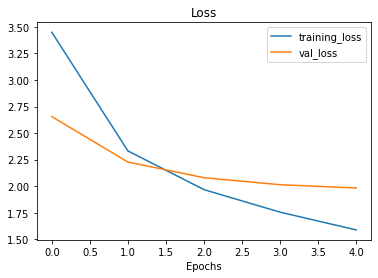

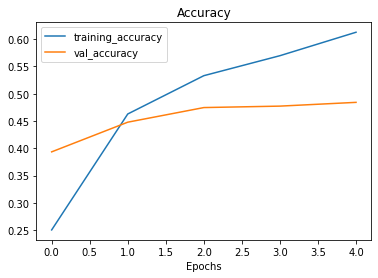

In [16]:
plot_loss_curves(history_all_classes_10_percent)

**Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting  (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [17]:
# Unfreeze all of the layer in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [18]:
# Adding wandb lr config for fine-tuning model
wandb.config.lr = 0.0001

# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.lr),
              metrics=['accuracy'])

In [19]:
# What layers in the model are trainable?
for layer_number, layer in enumerate(model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_aumgmentation True
2 efficientnetb0 True
3 global_avg_pool_layer True
4 output_layer True


In [20]:
# How many layer in base_model (efficientnetb0) are trainabel?
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Setup wandb init and config
wandb.init(project='food_vision',
           entity='jpao',
           name='model_10_percent_fine_tune',
           config={'epochs': fine_tune_epochs,
                  'val_steps': 0.15,
                  'n_train': len(train_data_all_10_percent.class_names),
                  'lr': 0.0001})

# Fine-tune fit our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                   epochs=wandb.config.epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(wandb.config.val_steps * len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                   callbacks=[WandbCallback()])

accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
accuracy,0.61241
best_epoch,4
best_val_loss,1.9835
epoch,4
loss,1.5883
val_accuracy,0.48411


Epoch 5/10
237/237 [==============================] - 56s 206ms/step - loss: 1.3639 - accuracy: 0.6421 - val_loss: 1.8819 - val_accuracy: 0.5074 - _timestamp: 1655363114.0000 - _runtime: 58.0000
Epoch 6/10
237/237 [==============================] - 42s 175ms/step - loss: 1.2415 - accuracy: 0.6696 - val_loss: 1.8888 - val_accuracy: 0.5013 - _timestamp: 1655363156.0000 - _runtime: 100.0000
Epoch 7/10
237/237 [==============================] - 41s 172ms/step - loss: 1.1516 - accuracy: 0.6927 - val_loss: 1.8791 - val_accuracy: 0.5101 - _timestamp: 1655363197.0000 - _runtime: 141.0000
Epoch 8/10
237/237 [==============================] - 39s 164ms/step - loss: 1.0760 - accuracy: 0.7098 - val_loss: 1.9038 - val_accuracy: 0.5042 - _timestamp: 1655363278.0000 - _runtime: 222.0000
Epoch 9/10
237/237 [==============================] - 38s 160ms/step - loss: 1.0125 - accuracy: 0.7343 - val_loss: 1.9189 - val_accuracy: 0.5053 - _timestamp: 1655363316.0000 - _runtime: 260.0000
Epoch 10/10
237/237 [

In [22]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 57s 72ms/step - loss: 1.6169 - accuracy: 0.5740


[1.6169095039367676, 0.5739802122116089]

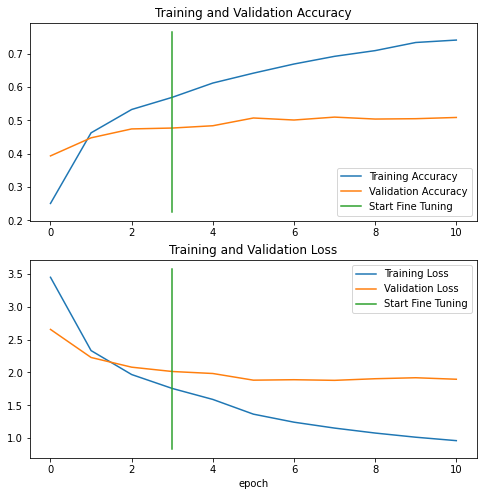

In [23]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=history_all_classes_10_percent.epoch[-1])

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [24]:
# Save our fine-tuning model
model.save('101_food_classes_10_percent_saved_big_dog_model')

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model/assets


In [25]:
# Load the saved model
loaded_model = tf.keras.models.load_model('101_food_classes_10_percent_saved_big_dog_model')

In [26]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 73ms/step - loss: 1.6169 - accuracy: 0.5740


[1.6169095039367676, 0.5739802122116089]

In [27]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.6169095039367676, 0.5739802122116089]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [28]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-06-16 07:15:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  67.3MB/s    in 0.7s    

2022-06-16 07:15:41 (67.3 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [29]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [30]:
# Load in saved model
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [31]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [32]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 62s 77ms/step


In [33]:
len(test_data)

790

In [34]:
# How many predictions are there?
len(preds_probs)

25250

In [35]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [36]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9541997e-02, 3.5742044e-06, 4.1377008e-02, ..., 1.4138679e-09,
        8.3530824e-05, 3.0897509e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780820e-04, ..., 5.4287048e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533648e-05, 1.4866963e-03, ..., 7.1891270e-07,
        5.4397265e-07, 4.0275925e-05],
       ...,
       [4.7313246e-01, 1.2931228e-07, 1.4805609e-03, ..., 5.9750048e-04,
        6.6969005e-05, 2.3469245e-05],
       [4.4571832e-02, 4.7265476e-07, 1.2258517e-01, ..., 6.3498501e-06,
        7.5318512e-06, 3.6778776e-03],
       [7.2438955e-01, 1.9249771e-09, 5.2310937e-05, ..., 1.2291373e-03,
        1.5792714e-09, 9.6395648e-05]], dtype=float32)

In [39]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9541997e-02, 3.5742044e-06, 4.1377008e-02, 1.0660534e-09,
        8.1614111e-09, 8.6639478e-09, 8.0927191e-07, 8.5652403e-07,
        1.9859070e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532185e-04, 7.8049184e-10, 7.4230076e-04, 3.8916409e-05,
        6.4740357e-06, 2.4977301e-06, 3.7891128e-05, 2.0678326e-07,
        1.5538435e-05, 8.1507017e-07, 2.6230514e-06, 2.0010684e-07,
        8.3827518e-07, 5.4216030e-06, 3.7390816e-06, 1.3150530e-08,
        2.7761480e-03, 2.8051860e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688880e-04, 7.6406842e-10, 4.0452872e-04, 1.3150632e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062943e-02, 8.2466846e-07,
        8.5365838e-07, 1.7138658e-06, 7.0525025e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681568e-06, 1.8525114e-07,
        3.3619767e-08, 3.1522580e-04, 1.0410922e-05, 8.5448272e-07,
        8.4741855e-01, 1.0555444e-05, 4.4094620e-07, 3.7404177e-05,
        3.5306122e-05, 3.2489035e-05, 6.7314730e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [40]:
# We get one prediction probability per class (in our case there's 101 prediction probability)
print(f'Number of prediction probabilities for sample 0: {len(preds_probs[0])}')
print(f'What prediction probability sample 0 looks like:\n {preds_probs[0]}')
print(f'The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9541997e-02 3.5742044e-06 4.1377008e-02 1.0660534e-09 8.1614111e-09
 8.6639478e-09 8.0927191e-07 8.5652403e-07 1.9859070e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532185e-04 7.8049184e-10 7.4230076e-04
 3.8916409e-05 6.4740357e-06 2.4977301e-06 3.7891128e-05 2.0678326e-07
 1.5538435e-05 8.1507017e-07 2.6230514e-06 2.0010684e-07 8.3827518e-07
 5.4216030e-06 3.7390816e-06 1.3150530e-08 2.7761480e-03 2.8051860e-05
 6.8562017e-10 2.5574853e-05 1.6688880e-04 7.6406842e-10 4.0452872e-04
 1.3150632e-08 1.7957391e-06 1.4448174e-06 2.3062943e-02 8.2466846e-07
 8.5365838e-07 1.7138658e-06 7.0525025e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681568e-06 1.8525114e-07 3.3619767e-08 3.1522580e-04
 1.0410922e-05 8.5448272e-07 8.4741855e-01 1.0555444e-05 4.4094620e-07
 3.7404177e-05 3.5306122e-05 3.2489035e-05 6.7314730e-05 1.2852565e-08
 2.6219704e-10 1.0318108e-05 8.5744112e-05 1.

In [43]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they lok?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [44]:
# How many pred classes do we have?
len(pred_classes)

25250

In [54]:
import numpy as np
true_label = []
for image, label in test_data:
  true_label.append(tf.argmax(label[1]).numpy())
true_label = np.asarray(true_label)

In [55]:
true_label

array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,
         1,   1,   1,   2,   2,   2,   2,   2,   2,   2,   2,   3,   3,
         3,   3,   3,   3,   3,   3,   4,   4,   4,   4,   4,   4,   4,
         4,   5,   5,   5,   5,   5,   5,   5,   6,   6,   6,   6,   6,
         6,   6,   6,   7,   7,   7,   7,   7,   7,   7,   7,   8,   8,
         8,   8,   8,   8,   8,   8,   9,   9,   9,   9,   9,   9,   9,
         9,  10,  10,  10,  10,  10,  10,  10,  11,  11,  11,  11,  11,
        11,  11,  11,  12,  12,  12,  12,  12,  12,  12,  12,  13,  13,
        13,  13,  13,  13,  13,  13,  14,  14,  14,  14,  14,  14,  14,
        14,  15,  15,  15,  15,  15,  15,  15,  16,  16,  16,  16,  16,
        16,  16,  16,  17,  17,  17,  17,  17,  17,  17,  17,  18,  18,
        18,  18,  18,  18,  18,  18,  19,  19,  19,  19,  19,  19,  19,
        19,  20,  20,  20,  20,  20,  20,  20,  20,  21,  21,  21,  21,
        21,  21,  21,  22,  22,  22,  22,  22,  22,  22,  22,  2